In [48]:
import pandas as pa
import numpy as np
import pdb
import sys
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from collections import defaultdict

##    Helper Functions (do not edit!) 

The Tree_node class represents one NODE in a DecisionTree.

Each NODE holds a left and a right child if it is not a leaf. 

If it is a leaf, it will contain the partition of the original dataset corresponding to the respective leaf.
In a fully grown tree every leaf is pure with respect to the goal variable (=label). The label in this example is the "rating".

Each NODE needs to have a split criterion that describes how the dataset is partitioned. It is a Python tuple containing:
- The variable ("feature") in which the dataset is split (e.g. "No. of doors")
- The cutoff value for the split (e.g. "4")
- The goal variable for which the split is optimized (in this example: "rating"); it is according to this variable that the  metric (e.g. the gini gain) is calculated

In [49]:
class Tree_node:
    original_Data = None
    
    def __init__(self,split=None,right_child=None, left_child=None):
        self.split=split
        self.right_child = right_child
        self.left_child = left_child

    # returns the child in which obs (=observation) belongs
    def return_child(self,obs):
        column = self.split[0]
                        
        if self.is_categorical(column):
            if obs[column] == self.split[1]:
                return self.right_child
            else:
                return self.left_child
            
        else:
            if obs[column] >= self.split[1]:
                return self.right_child
            else:
                return self.left_child
    
    # returns an estimate for the goal variable of obs
    def classify(self, obs):
        
        child = self.return_child(obs)
        
        if child.__class__.__name__ == 'Tree_node':
            return child.classify(obs)
    
        target_col = self.split[2]
        if self.is_categorical(target_col):
            #print("majority vote")
            return child[target_col].value_counts().keys()[0]
        else:
            #print("average")
            return np.average(child[~child[target_col].isnull()]["age"])
 
    # determines if the column ("feature") is categorical (e.g., "no. of doors") or numerical (e.g., "price")
    def is_categorical(self, column):
        category=True
        if not Tree_node.original_Data[column].dtype.name == "category":
            category = False
        return category
    
# returns the gini impurity for data with respect to column (i.e., use your goal variable as column here)    
def gini_impurity(data, column, weights=None):
    try:
        counts = uniquecounts(data, column)
        probs = counts/data.shape[0]
        if len(probs) == 1:
            prob_obs = np.ones(data.shape[0])
        else:
            la1 = lambda x: probs[probs.index == x][0]
            prob_obs = np.array(list(map(la1, data[column])))
            prob_obs = np.square(prob_obs)

        if weights is None:
            weights = np.ones(data.shape[0])
        weights = weights/sum(weights)
        return 1-sum(weights*prob_obs)
    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise
       

# Count ocurrences of every possible value for the given column
def uniquecounts(data, column):
   val_cnt = data[column].value_counts()
   return val_cnt.drop(val_cnt[val_cnt == 0].index)


# This is a helper function that partitions a dataset with respect to a given variable and a cutoff value
def divideset(in_set, column, value):
   # Make a function that tells us if a row is in the first group (true) or the second group (false)
   split_function=None
   if not in_set[column].dtype.name == "category":
      # assume it to be numerical if not categorical
      split_function=lambda in_set:in_set[column]>=value
   else:
      split_function=lambda in_set:in_set[column]==value
                                   
   # Divide the rows into two sets and return them
   set1= in_set[split_function(in_set)].copy()
   set2= in_set[np.invert(split_function(in_set))].copy()
   return (set1,set2)

##    Load Data     

In [50]:
dat_car = pa.read_csv('car.data.csv', sep=",")
dat_car.dtypes
for i in dat_car.columns.values:
    dat_car[i] = dat_car[i].astype('category')

dat = dat_car
target_col = "rating"

# shuffle data
np.random.seed(42)
#dat = dat.reindex(np.random.permutation(dat.index))
dat = dat.sample(frac=1)

# split data into training and test set -> this is absolutely central to fitting a ML model!
# If you are not sure why, ask your lecturer (it is likely to be on the final exam!)
split = int(dat.shape[0]/100*20)
                         
dat_test = dat.iloc[0:split]
dat_train = dat.iloc[(split+1):dat.shape[0]]

Tree_node.original_Data = dat_train

# Task 0
Look at the dataset. 
The dataset contains information about used cars that are for sale, including a rating of the offer (last column in the dataset).

In [51]:
print(dat_train.shape)

print(list(dat_train.columns))

print(list(dat_train.rating.unique()))
# In this exercise, we will fit a model to the remainig six variables in order to predict "rating", our goal variable.
# You will have to add your own code at each failing assert like this one
#assert False, "Please comment me"

(1295, 7)
['buy_price', 'maintenance', 'doors', 'persons', 'lug_space', 'safety', 'rating']
['unacc', 'acc', 'vgood', 'good']


## Task 1
Fit a tree stump: in this task you will fit a tree stump (i.e., a Decision Tree of depth 1, only containing a single split) to the data. You will have to find the partition of the input dataset that yields the biggest gini score gain with respect to the goal variable. You will accomplish this by exhaustive search, i.e., by trying every possible partition.

# Input Parameters:
1. in_set: the training data (features)
2. traget_col: the ground truth / labels (here: the "rating" column)
3. weights: weight of each sample (can be ignored at the beginning) 

# Outputs:
1. best_split: a tuple including the name of the most discriminant (best) feature for splitting, the corresponding threshold, and the name of the label column (see also comment above at "Helper functions"
2. best_sets: a tuple of two sets, which are the outputs of the "divideset" function; these sets are the result of dividing the training data based on the best split


In [52]:
def find_best_split(in_set, target_col, weights=None):
    # compute the gini score for the unpartitioned dataset
    in_score = gini_impurity(in_set, target_col,weights)

    best_gain = 0
    best_split = None
    best_sets = None
    
    # try every column
    for act_col in in_set.columns.values:
        # ignore goal variable - otherwise its trivial
        if act_col == target_col: continue
        # construct a list of unique values for this variable 
        column_values = set(in_set[act_col])

        #assert False, "find_best_split not implemented yet"
        
        # Try every possible split of the dataset w.r.t. the current variable
        # save the split that yielded the hightest gini gain
        # The gini-gain of a partition is defined as follows (assume the original set is partitioned into part_1 and part_2):
        #   gain = gini_impurity(set) - p_1*gini_impurity(part_1) - (1-p_1)*gini_impurity(part_2)
        # where p_1 = nrows(part_1)/nrows(set)
        # Hint: see Tree_node comments for the definition of the split
        for current_column_value in column_values:
            (part_1, part_2) = divideset(in_set, act_col, current_column_value)
            p_1 = part_1.shape[0]/in_set.shape[0]
            gain = gini_impurity(in_set, act_col, weights) - p_1*gini_impurity(part_1, act_col, weights) 
            - (1-p_1)*gini_impurity(part_2, act_col, weights)
            if gain > best_gain:
                best_gain = gain
                best_sets = (part_1, part_2)
                best_split = (act_col, current_column_value, target_col)
            
       

  
    return best_split, best_sets


# Fitting a stump is trivial when you have found the best split
split, sets = find_best_split(dat_train, target_col)
stump = Tree_node(split, sets[0], sets[1])

print(stump.split)

('doors', '5more', 'rating')


## Task 2
Compute the confusion matrix and the correct classification percentage for your tree.

# Input Parameters:
1. in_data: data samples (features)   
2. target_col: nameof column containing data labels 
3. tree: a trained tree (or stump) for evaluating the samples

# Outputs:
1. conf_mat: confusion matrix of the decisions based on the input data and given tree  
2. p_correct: probability of correct decisions (also called accuracy of the classifier)


In [53]:
def conf_matrix(in_data, target_col, tree):
  
    # distinct values available in the target variable (in this example: 4 levels of accpetability of the car)
    levels = uniquecounts(in_data, target_col).keys()
    # confusion matrix itself
    conf_mat =   pa.DataFrame(0, columns=levels.sort_values(), index=levels.sort_values())
                 
    # percentage of correct classifications
    correct_predicted = 0    

    for index, row in in_data.iterrows():
        predicted_target_col = tree.classify(row)
        real_target_col = row[target_col]
        if predicted_target_col == real_target_col:
            correct_predicted = correct_predicted + 1
        conf_mat[real_target_col][predicted_target_col] += 1     
    
    return conf_mat, correct_predicted/ len(in_data.index)

# Build confusion matrix with training data
conf_mat_stump_train, p_correct_stump_train = conf_matrix(dat_train, target_col,stump)


# Build confusion matrix with test data
conf_mat_stump_test, p_correct_stump_test = conf_matrix(dat_test, target_col,stump)
print(conf_mat_stump_train)
print(p_correct_stump_train)
print(conf_mat_stump_test)
print(p_correct_stump_test)

       acc  good  unacc  vgood
acc      0     0      0      0
good     0     0      0      0
unacc  318    58    868     51
vgood    0     0      0      0
0.6702702702702703
       acc  good  unacc  vgood
acc      0     0      0      0
good     0     0      0      0
unacc   66    11    233     14
vgood    0     0      0      0
0.7191358024691358


## Task 3
Recursively build a tree of variable depth.

# Input Parameters:
1. in_data: training data (features)
2. traget_col: name of column within in_data that contains the ground truth labels
3. max_depth: maximum depth of the tree
3. weights: weight of the samples

# Output:
An instance of the "Tree_node" class, initialized by a split (output of the "find_best_split" function) in addition to a recursive call of the "train_tree" function for two subsets of training data in the right and left children.

In [54]:
def train_tree(in_data,target_col,max_depth=99, weigths = None):
    # To recursively build a decision tree, you have to do two things:
    # - if you hit your stopping criterion, just return in_data (there are two optional criteria to stop the recursion)
    # - otherwise, find the best split and call this method on both partition sets

    #assert False, "recursively build tree here"
    if max_depth == 0 or len(uniquecounts(in_data, target_col)) == 1:
        return in_data
    else:
        split, sets = find_best_split(in_data, target_col, weigths)
        left_child =  train_tree(sets[1], target_col, max_depth - 1)
        right_child = train_tree(sets[0], target_col, max_depth - 1)   
    return Tree_node(split,right_child, left_child)

# Build a tree of depth 5 (a fully grown tree is pretty slow, but you can play around with the depth parameter and have a look
# at its influence on the classification performance)
depth5_tree = train_tree(dat_train, target_col, 5)

# Build confusion Matrix with training data
conf_mat_5_train, p_correct_5_train = conf_matrix(dat_train, target_col,depth5_tree)

# Build confusion Matrix with test data 
conf_mat_5_test, p_correct_5_test = conf_matrix(dat_test, target_col,depth5_tree)
print("Tree with depth 5:")
print(conf_mat_5_train)
print(p_correct_5_train)
print(conf_mat_5_test)
print(p_correct_5_test)

depth_tree = train_tree(dat_train, target_col, 10)
# Build confusion Matrix with training data
conf_mat_train, p_correct_train = conf_matrix(dat_train, target_col,depth_tree)

# Build confusion Matrix with test data 
conf_mat_test, p_correct_test = conf_matrix(dat_test, target_col,depth_tree)
print("Tree with depth 10:")
print(conf_mat_train)
print(p_correct_train)
print(conf_mat_test)
print(p_correct_test)

Tree with depth 5:
       acc  good  unacc  vgood
acc     33     4     25      5
good     0     0      0      0
unacc  285    54    843     46
vgood    0     0      0      0
0.6764478764478764
       acc  good  unacc  vgood
acc      5     0      8      1
good     0     0      0      0
unacc   61    11    225     13
vgood    0     0      0      0
0.7098765432098766
Tree with depth 10:
       acc  good  unacc  vgood
acc    207     0     29      4
good     0    42      0      0
unacc  107    14    822      5
vgood    4     2     17     42
0.8594594594594595
       acc  good  unacc  vgood
acc     27     2     37      2
good     3     2      3      3
unacc   36     7    182      9
vgood    0     0     11      0
0.6512345679012346


## Task 4
In this task, you repeat task 3 and 2, this time using the popular ML library scikit-learn instead of your own custom implementation.

Depth 5:
0.8734567901234568
Depth 10:
0.9845679012345679


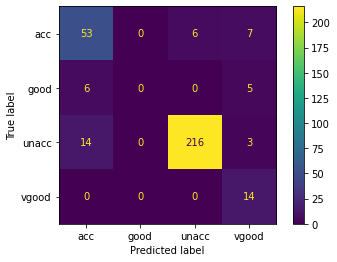

In [55]:
# Encoding of the target variable (label): the data has to be encoded as described below for sklearn. Don't worry about the
# next 3 lines - just use the _encoded version when you pass data to sklearn
d = defaultdict(LabelEncoder)
dat_train_encoded = dat_train.apply(lambda x: d[x.name].fit_transform(x))
dat_test_encoded = dat_test.apply(lambda x: d[x.name].transform(x))

# Hints: Have a look at the DecisionTreeClassifier class. Use criterion="gini" and max_depth=5 to make the results 
# comparable to task 3. You might have to take a look at the sklearn documentation.
# Attention: If you pass data to sklearn, you have to remove the target variable - otherwise sklearn will use it for 
# the prediction (e.g. use: dat_train_encoded[dat_train_encoded.columns.difference([target_col])] as training data)
#assert False, "Allocate a decision tree, fit it to the training data and compute the predictions for the goal variable using sklearn"
clf = DecisionTreeClassifier(criterion="gini", max_depth=5)
clf.fit(dat_train_encoded[dat_train_encoded.columns.difference([target_col])], dat_train_encoded[target_col])

predictions = clf.predict(dat_test_encoded[dat_test_encoded.columns.difference([target_col])])

# Inverse the encoding on the predictions and compute the confusion rate --> how does this compare to your own implementation?
predictions = d[target_col].inverse_transform(predictions)
print("Depth 5:")
print(sum(dat_test[target_col] == predictions)/float(len(predictions)))
print("Depth 10:")
clf2 = DecisionTreeClassifier(criterion="gini", max_depth=10)
clf2.fit(dat_train_encoded[dat_train_encoded.columns.difference([target_col])], dat_train_encoded[target_col])

predictions = clf2.predict(dat_test_encoded[dat_test_encoded.columns.difference([target_col])])

# Inverse the encoding on the predictions and compute the confusion rate --> how does this compare to your own implementation?
predictions = d[target_col].inverse_transform(predictions)
print(sum(dat_test[target_col] == predictions)/float(len(predictions)))

# Task 5
In this task, you will implement the AdaBoost algorithm to fit a number of trees and use their collective power
to build a better classifier. While you can use your own tree implementation, we advise you to use DecisionTreeClassifier
for performance reasons (one run of AdaBoost will fit 50 trees by default). Using the following function, you will fit decision trees to the data using Adaboost:

# Input Parameters (ada_boost_trees):
1. in_data: training data (features)
2. column: name of column containing the ground truth labels 
3. depth: depth of the individual trees
4. m: number of trees (hypotheses) to fit

# Outputs (ada_boost_trees):
1. trees: a list of fitted trees
2. importance: a list of the respective importances (weights) for the fitted trees; these values are used for final weighted decisions 

# Input Parameters (predict_boosted_trees):
1. trees: a list of the fitted trees
2. importance: a list of the respective importances (weights) for the fitted trees; these values are used for final weighted decisions 
3. obs: data samples ("observations") used for evaluation

# Output (predict_boosted_trees):
1. trees: a list of the fitted trees
2. importance: a list of the respective importances (weights) for the fitted trees; these values are used for final weighted decisions. 

In [60]:
def ada_boost_trees(in_data, column, depth, m):
    trees = []
    importance = []
    
    N, _ = in_data.shape
    # initialize weights uniformly
    w = np.ones(in_data.shape[0]) * float(1)/in_data.shape[0]
    
    for k in range(m):
        # fit tree using actual weights
        d_tree = DecisionTreeClassifier(criterion = "gini", max_depth=depth)
        d_tree = d_tree.fit(in_data[in_data.columns.difference([target_col])],  in_data[target_col], sample_weight=w)
        predictions = d_tree.predict(in_data[in_data.columns.difference([target_col])])            

        # compute the weighted error
        # i.e. sum up w but leave out each value for which the prediciton is correct
        #assert False, "compute weighted_err here"
        weighted_err = 0
        
        for index, predicted in enumerate(predictions):
            if(predicted != in_data[column].iloc[index]):
                weighted_err += w[index]

        
        # stop if there are no errors
        if weighted_err == 0:
            break
            
        # model importance
        model_imp = np.log((1-weighted_err)/(weighted_err))
        
        # update weights
        # Option1 "by a linear factor": for each correctly labeled sample: w = w * weighted_err/(1-weighted_err) 
        # Option2 "by exp(influence) in case of error": for each  misclassified sample: w = w*exp(model_imp) 
        # Option3: Can you think of a better way to "boost the weights"
        # normalize w
        #assert False, "update w here"
        for index, weight in  enumerate(w):
             if(predictions[index] == in_data[column].iloc[index]):
                    w[index] = w[index]  * weighted_err/(1-weighted_err)
        w = w / sum(w)
        
        trees.append(d_tree)
        importance.append(model_imp)
        
    return trees, importance

# predicts the class of a number of observations, based on trees and importances returned by the above method
def predict_boosted_trees(trees, importance, obs):
    N, _ = obs.shape
    
    predictions_dir = dict()
    
    for (tree, model_imp) in zip(trees, importance):
        if model_imp == 0: continue

        predictions = tree.predict(obs)
        levels = set(predictions)
        
        for level in levels:
            if level in predictions_dir.keys():               
                predictions_dir[level] += (predictions == level)*(model_imp)
            else:
                predictions_dir[level] = (predictions == level)*(model_imp)
                
    pred = np.zeros((N,len(predictions_dir.keys())))
    
    for k in predictions_dir.keys():
        pred[:,k]=predictions_dir[k]        
        
    return np.argmax(pred, axis=1)

# based on the code in predict_boosted_trees, how does the prediction based on a number of boosted trees work?
#assert False, "write in own words - 2 to 3 sentences"
#Für jeden übergebenen Baum, wird im selben Dict augeführt was für eine model importance er hat für den predicteten Wert.
#Nach einer Umformung in ein array von Paaren von einer Observation und einem array von prediction, wird ausgelesen, 
#an welchem Index der höchste Wert steht und so eine Ensemble learning prediction abgeben.

# train boosted trees
trees, importance = ada_boost_trees(dat_train_encoded, target_col, 5, 50)

# predict using boosted trees
predictions = predict_boosted_trees(trees, importance,dat_test_encoded[dat_test_encoded.columns.difference([target_col])])
predictions = d[target_col].inverse_transform(predictions)

# compute prediction accuracy of the boosted trees
print(sum(dat_test[target_col] == predictions)/float(len(predictions)))


0.9876543209876543


## Task 6
Compare our Adaboosted Trees versus sklearn. Fit an sklearn AdaBoostClassifier using a DecisionTreeClassifier as base classifier.

0.9783950617283951


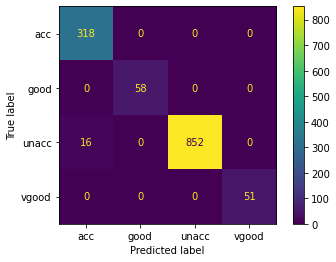

In [61]:
seed = 42

#assert False, "define, fit an AdaBoostClassifier and use it do make predictions"
bdt = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion="gini", max_depth=5), random_state=seed, n_estimators=50)
bdt.fit(dat_train_encoded[dat_train_encoded.columns.difference([target_col])], dat_train_encoded[target_col])

predictions = bdt.predict(dat_test_encoded[dat_test_encoded.columns.difference([target_col])])
predictions = d[target_col].inverse_transform(predictions)

print(sum(dat_test[target_col] == predictions)/float(len(predictions)))